# Training MLP AE

What if we have neither spatial nor temporal information? Only using the node features, can we detect anomalies?

In [21]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import MLPAutoencoder
from parameters import MLPAEParameters, TrainingParameters
from datautils import get_morning_data, get_temporal_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_rstae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, train_mlpae, test_mlpae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc , discrete_fp_delays_loc
import torch.nn as nn
from tqdm import tqdm

import random
import os
import torch_geometric
seed = 42
torch_geometric.seed_everything(seed)

### Time Series Sequencing

In [22]:
def sequence_mlp(data, timesteps, hide_anomalies=False):
    sequence = []
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not

        combined = np.array(data_t)
        combined = np.swapaxes(combined, 0, 1)
        combined = torch.tensor(combined, dtype=torch.float32)
        
        curr_data = combined[:,-1,:]
        sequence.append([combined, curr_data])

    return sequence, kept_indices

### Loading Hyperparameters

In [23]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [24]:
hide_anomalies = False
optimal_hyperparams = load_best_parameters('mlp',hide_anomalies=hide_anomalies)

In [25]:
training_params = TrainingParameters( 
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=1,
    n_epochs=optimal_hyperparams['epochs'],
)

In [26]:
hyperparams =MLPAEParameters(
    num_features=3,
    latent_dim=2,
    hidden_dim=optimal_hyperparams['hidden_dim'],
)

In [27]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_mlp(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_mlp(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)

100%|██████████| 2879/2879 [00:02<00:00, 1101.80it/s]


In [28]:
# ae = MLPAutoencoder(hyperparams)

### Model Training or Loading

In [29]:
using_pretrained = True

In [30]:
if not using_pretrained:
    ae, losses = train_mlpae(params=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, f'mlpae_{hide_anomalies}_{seed}')
else:
    ae = load_model(MLPAutoencoder, hyperparams,  f'mlpae_{hide_anomalies}_{seed}')

In [31]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [32]:
from training import compute_anomaly_threshold_mlpae

In [33]:
thresh = compute_anomaly_threshold_mlpae(val_sequence, ae, mse_weights, 'max')

100%|██████████| 2879/2879 [00:00<00:00, 20125.27it/s]


### Loading Test Data

In [34]:
_, df_test_data, _ = get_full_data()

In [35]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_mlp(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4799/4799 [00:05<00:00, 831.08it/s]


In [36]:
test_errors, test_recons_speeds, test_true_speeds = test_mlpae(test_data, mse_weights, ae)

In [37]:
test_recons_speeds = test_recons_speeds.squeeze()

In [38]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
# crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [39]:
converted_dates_utc = pd.to_datetime(df_test_data.unix_time, unit='s', utc=True)

# Step 2: Convert to US/Central timezone
converted_dates_central = converted_dates_utc.dt.tz_convert('US/Central')
converted_dates_naive = converted_dates_central.dt.tz_localize(None)
df_test_data['Time']=converted_dates_naive

import glob
pattern=sorted(glob.glob('../data/event_data/2023-10-*.csv'))
events=pd.DataFrame()
for i in pattern:
    event=pd.read_csv(i,sep=';')
    events=pd.concat([events,event],axis=0)
events.reset_index(drop=True,inplace=True)
# events['timestamp']=pd.to_datetime(events['event_update_time'],utc=False)
events['Time'] = pd.to_datetime(events['event_update_time'], utc=False)

# To ensure the timestamps are naive (no timezone)
events['Time'] = events['Time'].dt.tz_localize(None).dt.floor('1s').dt.ceil('30s')
events=events[(events['event_update_type'] == 'new') & (events['classification']=='incident')]
events.drop_duplicates(subset=['event_id'],inplace=True)
events=events.sort_values(by='Time').reset_index(drop=True)


array1=np.array(events.milemarker.sort_values().unique())
array2=np.array(df_test_data.milemarker.unique())
def find_closest_or_exact(target, array):
    # Find the indices where the target would fit
    idx = np.searchsorted(array, target)
    
    # Check for exact match
    if idx < len(array) and array[idx] == target:
        return array[idx]  # Exact match
    
    # Find the closest lower value (if it exists)
    lower = array[idx - 1] if idx > 0 else None
    
    # Find the closest higher value (if it exists)
    higher = array[idx] if idx < len(array) else None
    
    return [lower, higher]

# Mapping from array2 to closest values in array1
events['mapped_milemarkers'] = events['milemarker'].apply(lambda x: find_closest_or_exact(x, array2))
events=events.explode('mapped_milemarkers')
# Filter events based on Time in df_test_data
test_events = events[events['Time'].isin(df_test_data['Time'])]

# Ensure 'Time' in test_events is properly converted to pandas.Timestamp
test_events['Time'] = pd.to_datetime(test_events['Time'])

df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
test_events['combined'] = test_events['Time'].astype(str) + '_' + test_events['mapped_milemarkers'].astype(str)

df_test_data['exists'] = df_test_data['combined'].isin(test_events['combined']).astype(int)
df_test_data['crash_record']=((df_test_data['exists'] == 1) & (df_test_data['crash_record'] == 1)
).astype(int)
crash_reported=df_test_data['crash_record'].to_numpy().reshape(-1,196)[kept_test_indices]



/tmp/ipykernel_1385903/3884504702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data['Time']=converted_dates_naive
/tmp/ipykernel_1385903/3884504702.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_events['Time'] = pd.to_datetime(test_events['Time'])
/tmp/ipykernel_1385903/3884504702.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [40]:
path_results = 'saved_results/mlp/'
results = discrete_fp_delays_loc(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
# results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

100%|██████████| 1000/1000 [00:28<00:00, 35.57it/s]

Found FPR of 0.00980392156862745 for 0.01
Found FPR of 0.024509803921568627 for 0.025
Found FPR of 0.0494281045751634 for 0.05
Found FPR of 0.0988562091503268 for 0.1
Found FPR of 0.198937908496732 for 0.2
FPR 1% gives mean delay of -3.125 +/- 7.179615240387189 with mean. distance of 1.1666666666666667 +/- 1.0628839175668348 while missing 0.6%.
FPR 2.5% gives mean delay of -5.0 +/- 9.027735042633894 with mean. distance of 1.8666666666666665 +/- 1.3951304200284962 while missing 0.6%.
FPR 5% gives mean delay of -3.3 +/- 8.795453370918407 with mean. distance of 3.966666666666667 +/- 2.876726534718855 while missing 0.5%.
FPR 10% gives mean delay of -7.285714285714286 +/- 7.30389887495098 with mean. distance of 3.295833333333333 +/- 3.570624264591401 while missing 0.30000000000000004%.
FPR 20% gives mean delay of -12.75 +/- 3.5355339059327378 with mean. distance of 3.392307692307692 +/- 3.8692498852563406 while missing 0.19999999999999996%.


In [41]:
calculate_auc(test_errors,anomaly_labels)

0.6204245844428306

### Compute FPR / Crash Detection Delay Tradeoff

In [20]:
test_errors.shape

(4799, 196)

In [21]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

  9%|▊         | 86/1000 [00:06<01:07, 13.44it/s]


KeyboardInterrupt: 

In [ ]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/mlpae_fp_delay.csv')

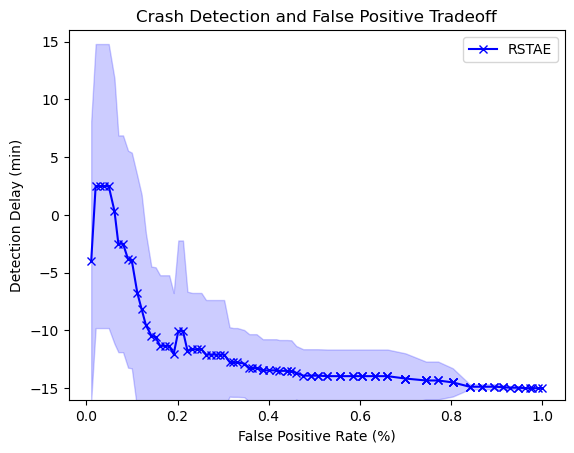

In [ ]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='RSTAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [ ]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

  0%|          | 4/1000 [00:00<00:30, 32.86it/s]

100%|██████████| 1000/1000 [00:28<00:00, 34.90it/s]

Found FPR of 0.010620915032679739 for 0.01
Found FPR of 0.024918300653594773 for 0.025
Found FPR of 0.049019607843137254 for 0.05
Found FPR of 0.09967320261437909 for 0.1
Found FPR of 0.20016339869281047 for 0.2
FPR 1% gives mean delay of -4.0 +/- 12.083045973594572 while missing 0.75%.
FPR 2.5% gives mean delay of 2.5 +/- 12.296340919151518 while missing 0.5833333333333333%.
FPR 5% gives mean delay of 2.5 +/- 12.296340919151518 while missing 0.5833333333333333%.
FPR 10% gives mean delay of -3.9444444444444446 +/- 9.337631285539784 while missing 0.25%.
FPR 20% gives mean delay of -10.05 +/- 7.837250793486196 while missing 0.16666666666666663%.


### Compute AUC

In [20]:
calculate_auc(test_errors, anomaly_labels)

0.6330022492536109

### Copmute Detection Delay Histogram on Full Dataset

In [ ]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [ ]:
full_sequence, kept_full_indices = sequence_mlp(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 38/18239 [00:00<00:48, 372.23it/s]

100%|██████████| 18239/18239 [00:47<00:00, 382.23it/s]


In [ ]:
full_errors, _, _ = test_mlpae(full_sequence, mse_weights, ae)

In [ ]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [ ]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [01:52<00:00,  8.91it/s]


In [ ]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


Found FPR of 0.10123799606618072 for 0.1


In [ ]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

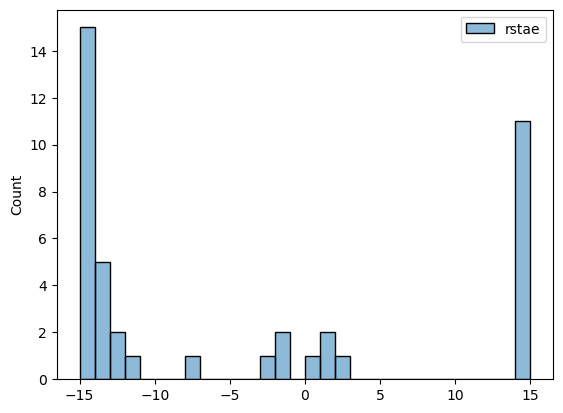

In [ ]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='rstae')
plt.legend()

In [ ]:
np.save('./saved_results/mlpae10delays.npy', np.array(delay)/2)

In [ ]:
_, df_clean_test_data, _ = get_full_data()

In [ ]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_mlp(clean_test_data, training_params.timesteps, hide_anomalies=True)

  8%|▊         | 380/4799 [00:00<00:04, 1039.18it/s]

100%|██████████| 4799/4799 [00:04<00:00, 1121.35it/s]


In [ ]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_mlpae(clean_test_data, mse_weights, ae)

In [ ]:
np.mean(clean_test_errors)

0.014061105

In [ ]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [ ]:
# data.to_csv('./saved_results/full_results_test_transformerae.csv')

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_transformerae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [ ]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [ ]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()